# BTC Predictor

In [84]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [85]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML

## Stock Predictor Lib


In [86]:
import json as js
import numpy as np
import pandas as pd
from ta import *
#from fastai.structured import *
#from fastai.column_data import *


class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.tail(sampleSize)
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train[self.index] = pd.to_datetime(self.train[self.index])

    def set_date_as_index_unix(self):
        self.train[self.index] = pd.to_datetime(
            self.train[self.index], unit='s')

    def split_train_validation(self, testRecordsCount, trainRecordsCount):
        self.test = self.train.tail(testRecordsCount)
        self.train = self.train.head(trainRecordsCount)
#        self.test.reset_index(inplace=True)
#        self.train.reset_index(inplace=True)
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close']]

    def clean_train(self):
        #     df = df.dropna()
        #     df = df.replace(np.nan,df.mean())
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train = self.train.fillna(method='bfill')
        print('Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        #        ,win_type='boxcar'
        max_in_lookahead_timeframe = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['action'] = max_in_lookahead_timeframe > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical(self, target, lookahead, percentIncrease):
        max_in_lookback_timeframe = self.train[target].rolling(
            window=lookahead, min_periods=1).max()
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookahead, percentIncrease):
        self.train['action'] = 0

        self.train.loc[self.train[target].rolling(
            window=lookahead).max() > self.train['Close'], 'action'] = 1

        self.train.loc[self.train[target].rolling(window=lookahead).max(
        ) > percentIncrease * self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
#         print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
#         print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.plot(
            x='index',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


## Config


In [87]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 25
percentIncrease = 1.005
recordsCount = 50000
testRecordsCount = 10000
trainRecordsCount = 40000
trainRatio = 0.90
lr = 1e-4
dropout = 0.06
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [88]:
table_names = [
    'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08-24'
]

In [89]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [90]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [91]:
train= tables[0]

In [92]:
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 50000 Original size: 3161057


In [93]:
p.save_to_feather()

## Data Cleaning

In [94]:
p.read_from_feather()
p.set_date_as_index_unix()

In [95]:
p.normalize_train('Volume_(BTC)','Open','High','Low','Close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close
0,2017-12-04 06:41:00,0.197672,11372.25,11372.26,11337.15,11369.31
1,2017-12-04 06:42:00,0.105675,11369.20,11369.46,11354.00,11354.00
2,2017-12-04 06:43:00,5.031403,11368.37,11371.28,11350.02,11368.69
3,2017-12-04 06:44:00,0.563592,11368.66,11377.03,11368.55,11377.03
4,2017-12-04 06:45:00,2.902495,11377.02,11400.00,11377.02,11400.00


In [96]:
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Feature Engineering

In [97]:
# add technical analysis
p.add_ta()
p.clean_train()

Train size: 50000


In [98]:
p.set_target('Close',lookahead, percentIncrease)

Buy count: 23724 Sell count: 26276


In [99]:
p.add_date_values()

## Split validation and test sets

In [100]:
p.split_train_validation(testRecordsCount, trainRecordsCount)
# p.test.reset_index(inplace=True)
# p.train.reset_index(inplace=True)

Train size: 40000 Test size: 10000


In [101]:
# p.train.to_feather(f'{PATH}train')
# p.test.to_feather(f'{PATH}test')

In [102]:
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_cr,action,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
0,2017-12-04 06:41:00,0.197672,11372.25,11372.26,11337.15,11369.31,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1000.000000,35.110000,11463.473073,11357.156927,11410.315,0.0,0.0,11388.151,11406.31,11369.992,0.0,0.0,11450.0,11354.0,0.0,0.0,0.000000,0.000000,0.000000,11369.310000,11369.310000,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,11397.1725,11417.62,50.000000,50.0,0.000000,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,1,2017,12,49,4,0,338,False,False,False,False,False,False,1512369660,6,41
1,2017-12-04 06:42:00,0.105675,11369.20,11369.46,11354.00,11354.00,0.058779,-0.105675,0.0,0.0,0.000000,0.0,0.000000,998.653392,24.946207,11463.473073,11357.156927,11410.315,0.0,0.0,11388.151,11406.31,11369.992,0.0,0.0,11450.0,11354.0,0.0,0.0,-0.161766,-0.085140,-0.076626,11361.348800,11361.510566,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,11397.1725,11417.62,0.000000,50.0,-100.000000,50.0,50.0,50.0,-50.0,0.0,-0.134661,-0.134661,1,2017,12,49,4,0,338,False,False,False,False,False,False,1512369720,6,42
2,2017-12-04 06:43:00,5.031403,11368.37,11371.28,11350.02,11368.69,3.699826,5.031403,0.0,0.0,-2.996913,0.0,0.006367,998.653392,23.631791,11463.473073,11357.156927,11410.315,0.0,0.0,11388.151,11406.31,11369.992,0.0,0.0,11450.0,11354.0,0.0,0.0,-0.000439,-0.053885,0.053446,11363.994136,11363.994575,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,11397.1725,11417.62,50.691297,50.0,-48.723520,50.0,50.0,50.0,-50.0,0.0,0.129382,-0.005453,1,2017,12,49,4,0,338,False,False,False,False,False,False,1512369780,6,43
3,2017-12-04 06:44:00,0.563592,11368.66,11377.03,11368.55,11377.03,4.369093,0.563592,0.0,0.0,10.545823,0.0,0.006923,999.385998,19.443299,11463.473073,11357.156927,11410.315,0.0,0.0,11388.151,11406.31,11369.992,0.0,0.0,11450.0,11354.0,0.0,0.0,0.214003,0.024012,0.189991,11367.654174,11367.440171,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,11397.1725,11417.62,62.312237,50.0,-25.962772,50.0,50.0,50.0,-50.0,0.0,0.073359,0.067902,1,2017,12,49,4,0,338,False,False,False,False,False,False,1512369840,6,44
4,2017-12-04 06:45:00,2.902495,11377.02,11400.00,11377.02,11400.00,3.466086,2.902495,0.0,0.0,-66.656125,0.0,0.006274,999.385998,20.251445,11463.473073,11357.156927,11410.315,0.0,0.0,11388.151,11406.31,11369.992,0.0,0.0,11450.0,11354.0,0.0,0.0,0.745340,0.200156,0.545184,11375.198038,11374.452698,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,11397.1725,11417.62,77.771441,50.0,-2.666690,50.0,50.0,50.0,-50.0,0.0,0.201898,0.269937,0,2017,12,49,4,0,338,False,False,False,False,False,False,1512369900,6,45


In [103]:
p.train.tail(50).T.head(100)

,39950,39951,39952,39953,39954,39955,39956,39957,39958,39959,39960,39961,39962,39963,39964,39965,39966,39967,39968,39969,39970,39971,39972,39973,39974,39975,39976,39977,39978,39979,39980,39981,39982,39983,39984,39985,39986,39987,39988,39989,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
Timestamp,2018-01-01 00:31:00,2018-01-01 00:32:00,2018-01-01 00:33:00,2018-01-01 00:34:00,2018-01-01 00:35:00,2018-01-01 00:36:00,2018-01-01 00:37:00,2018-01-01 00:38:00,2018-01-01 00:39:00,2018-01-01 00:40:00,2018-01-01 00:41:00,2018-01-01 00:42:00,2018-01-01 00:43:00,2018-01-01 00:44:00,2018-01-01 00:45:00,2018-01-01 00:46:00,2018-01-01 00:47:00,2018-01-01 00:48:00,2018-01-01 00:49:00,2018-01-01 00:50:00,2018-01-01 00:51:00,2018-01-01 00:52:00,2018-01-01 00:53:00,2018-01-01 00:54:00,2018-01-01 00:55:00,2018-01-01 00:56:00,2018-01-01 00:57:00,2018-01-01 00:58:00,2018-01-01 00:59:00,2018-01-01 01:00:00,2018-01-01 01:01:00,2018-01-01 01:02:00,2018-01-01 01:03:00,2018-01-01 01:04:00,2018-01-01 01:05:00,2018-01-01 01:06:00,2018-01-01 01:07:00,2018-01-01 01:08:00,2018-01-01 01:09:00,2018-01-01 01:10:00,2018-01-01 01:11:00,2018-01-01 01:12:00,2018-01-01 01:13:00,2018-01-01 01:14:00,2018-01-01 01:15:00,2018-01-01 01:16:00,2018-01-01 01:17:00,2018-01-01 01:18:00,2018-01-01 01:19:00,2018-01-01 01:20:00
Volume,1.19917,20.2918,0.505361,4.96789,0.110723,0.162831,11.702,3.17072,0.312759,5.12813,0.611623,4.33532,0.871489,1.78837,2.4758,0.116015,0.775738,6.85135,0.574298,3.66799,1.15904,1.27812,0.109093,0.0459614,13.2409,1.02044,0.19926,2.3952,1.49931,0.531898,9.46679,1.30616,1.14318,0.179416,0.860276,1.26541,8.65339,3.09669,15.4342,4.19633,1.03008,1.24946,0.272052,0.0454431,0.384441,0.885178,4.08005,0.283713,12.4654,18.4473
Open,13699.9,13686.4,13721.4,13711.4,13665,13727.1,13712,13669.3,13669.3,13727.5,13671.5,13647.6,13633.2,13671,13664,13661.7,13680.8,13716,13720,13720,13662.4,13732.8,13704.5,13693.6,13668.5,13622,13601,13628.5,13633.6,13635.1,13636.1,13678.9,13656,13675.4,13676.1,13679.5,13660,13600,13608,13587,13567,13614,13600,13600,13600,13567.8,13597,13643.9,13642.9,13675.2
High,13699.9,13721.4,13754.1,13727.9,13727.7,13727.1,13728.2,13710.9,13707.8,13731.5,13672.4,13671.7,13671,13671,13682.8,13680.8,13707.8,13720,13720,13742.3,13733.9,13733.1,13704.5,13693.6,13668.5,13630,13630,13651.9,13668.5,13681.4,13678.9,13680,13675.6,13676.1,13680,13679.7,13679.6,13610.2,13609.8,13595.4,13614,13614.1,13600,13600,13600,13599,13647,13643.9,13675.3,13694.1
Low,13672.6,13669.9,13711.4,13655.4,13665,13727,13668.4,13669.3,13669.3,13632.2,13646.6,13632.1,13632,13632,13632,13661.7,13655.7,13700,13700,13653.2,13662.4,13669.6,13668.5,13690.8,13622,13600.3,13601,13601,13633.6,13635.1,13636.1,13656,13656,13657,13660,13660,13600,13598,13564,13564,13564.1,13585.3,13565.7,13600,13565.2,13564.1,13576.3,13604.7,13605,13647.5
Close,13699,13721.4,13711.4,13665,13727.6,13727,13701.5,13707.8,13707.8,13706,13671.7,13633.2,13632,13664,13661.7,13680.8,13707.8,13720,13720,13655.5,13710,13669.6,13704.5,13690.8,13622,13630,13623.4,13651.8,13668.5,13681.4,13678.9,13656,13674.7,13676.1,13666.7,13660,13600,13610.2,13574,13567,13614,13614.1,13600,13600,13599,13597,13645,13618.5,13647.5,13694.1
volume_adi,2.13399,21.4049,19.7788,-4.16131,-3.5455,-0.0521436,1.12261,3.9875,3.01482,2.802,3.06731,-3.49928,-4.94883,0.276479,1.56734,0.535386,0.889966,7.6253,7.42507,-2.90002,-3.08912,-0.8935,-1.16909,0.0633988,-13.2865,-12.2205,1.12832,2.50214,3.89357,2.03121,9.99869,8.16063,-0.26887,1.21671,-0.104475,-1.5493,-9.9188,-5.5567,-5.61203,-12.1141,-2.37607,2.27871,1.52151,0.272052,0.362353,1.14616,4.62854,3.76043,2.50166,21.0333
volume_obv,-1.19917,20.2918,-0.505361,-4.96789,0.110723,-0.162831,-11.702,3.17072,0.312759,-5.12813,-0.611623,-4.33532,-0.871489,1.78837,-2.4758,0.116015,0.775738,6.85135,0.574298,-3.66799,1.15904,-1.27812,0.109093,-0.0459614,-13.2409,1.02044,-0.19926,2.3952,1.49931,0.531898,-9.46679,-1.30616,1.14318,0.179416,-0.860276,-1.26541,-8.65339,3.09669,-15.4342,-4.19633,1.

## Create features

In [104]:
# p.train = pd.read_feather(f'{PATH}train')
# p.test = pd.read_feather(f'{PATH}test')

Identify categorical vs continuous variables

In [105]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao']
# 'others_dr','others_cr'


n = len(p.train); n

p.test = p.test.set_index('Timestamp')
p.train = p.train.set_index('Timestamp')

len(contin_vars)

58

In [106]:
p.train = p.train[cat_vars+contin_vars+[dep]].copy()
# , index

In [107]:
# test[dep] = 0 
p.test = p.test[cat_vars+contin_vars+[dep]].copy()
# , index


In [108]:
for v in cat_vars: p.train[v] = p.train[v].astype('category').cat.as_ordered()
#     todo: maybe change dep variable to category here for multiclass option

In [109]:
apply_cats(p.test, p.train)
# test

In [110]:
for v in contin_vars:
    p.train[v] = p.train[v].astype('float32')
    p.test[v] = p.test[v].astype('float32')

In [111]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [112]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
p.train.head(30).T.head(70)

Timestamp,2017-12-04 06:41:00,2017-12-04 06:42:00,2017-12-04 06:43:00,2017-12-04 06:44:00,2017-12-04 06:45:00,2017-12-04 06:46:00,2017-12-04 06:47:00,2017-12-04 06:48:00,2017-12-04 06:49:00,2017-12-04 06:50:00,2017-12-04 06:51:00,2017-12-04 06:52:00,2017-12-04 06:53:00,2017-12-04 06:54:00,2017-12-04 06:55:00,2017-12-04 06:56:00,2017-12-04 06:57:00,2017-12-04 06:58:00,2017-12-04 06:59:00,2017-12-04 07:00:00,2017-12-04 07:01:00,2017-12-04 07:02:00,2017-12-04 07:03:00,2017-12-04 07:04:00,2017-12-04 07:05:00,2017-12-04 07:06:00,2017-12-04 07:07:00,2017-12-04 07:08:00,2017-12-04 07:09:00,2017-12-04 07:10:00
TimestampYear,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
TimestampMonth,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
TimestampWeek,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
TimestampDay,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
hour,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7
minute,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,0,1,2,3,4,5,6,7,8,9,10
TimestampDayofweek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TimestampDayofyear,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [113]:
nas={}

In [114]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-04 06:41:00,1,2,2,2,7,42,1,2,1,1,1,1,1,1,-1.936233,-1.937502,-1.948953,-1.938439,-0.664140,-1.732051,-0.091659,0.000465,0.001234,-0.42688,0.049875,0.047483,0.025289,-1.246248,-0.832568,-1.955575,-1.87654,-1.9176,-0.222695,-0.245628,-1.92773,-1.946343,-1.908831,-0.012248,-0.015813,-1.949484,-1.886447,-0.442792,-0.362245,-0.013377,-0.014435,0.000381,-1.938483,-1.939370,-0.072788,0.280391,0.029424,-0.858496,0.015134,0.209407,-1.206298,-0.011111,0.056691,-0.048471,-0.003235,-0.017475,-0.017917,0.000124,-1.917287,-1.903066,-0.103815,-0.048974,-0.121935,-0.472915,-0.215692,-0.232778,-0.215691,-0.007283
2017-12-04 06:42:00,1,2,2,2,7,43,1,2,1,1,1,1,1,1,-1.937732,-1.945027,-1.950330,-1.930158,-0.668915,-1.732051,-0.089631,-0.004131,0.001234,-0.42688,0.049875,0.047483,0.025289,-1.246626,-1.278716,-1.955575,-1.87654,-1.9176,-0.222695,-0.245628,-1.92773,-1.946343,-1.908831,-0.012248,-0.015813,-1.949484,-1.886447,-0.442792,-0.362245,-0.016101,-0.015967,-0.003472,-1.942399,-1.943209,-0.072788,0.280391,0.029424,-0.858496,0.015134,0.209407,-1.206298,-0.011111,0.056691,-0.048471,-0.003235,-0.017475,-0.017917,0.000124,-1.917287,-1.903066,-4.342515,-0.048974,-7.159120,-0.472915,-0.215692,-0.232778,-0.215691,-0.007283


In [115]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:21:00,2,1,1,1,2,22,1,1,1,2,1,2,1,2,-0.794839,-0.794714,-0.806865,-0.780110,-0.664927,1.732051,0.551106,0.008402,0.372201,-0.061269,-0.154182,-0.251202,0.276557,2.675831,-0.682097,-0.848780,-0.801930,-0.825995,-0.222695,-0.245628,-0.828933,-0.837953,-0.819794,-0.012248,-0.015813,-0.843329,-0.802377,2.258396,-0.362245,-0.427539,-0.589444,0.369968,-0.820539,-0.808586,-0.396989,0.525097,-0.169787,1.164827,0.863067,-0.128796,-0.246316,-0.351416,-0.318681,1.254548,-0.529144,-0.328489,-0.470760,0.412801,-0.793126,-0.769445,0.625962,0.672431,-0.694996,1.136964,1.302474,1.101439,1.302475,0.031685
2018-01-01 01:22:00,2,1,1,1,2,23,1,1,1,2,1,2,1,2,-0.794824,-0.790216,-0.801794,-0.795876,-0.653536,1.732051,-0.072252,0.017946,0.363114,0.009800,-0.009067,-0.607111,0.026361,2.675831,-0.670737,-0.844692,-0.803674,-0.824834,-0.222695,-0.245628,-0.824733,-0.833077,-0.816268,-0.012248,-0.015813,-0.838819,-0.802377,2.258396,-0.362245,-0.371065,-0.570175,0.484753,-0.818223,-0.807918,-0.580098,0.411974,0.236909,-0.858496,0.509686,-0.957559,0.115049,-0.272494,-0.247530,1.095353,-0.602218,-0.253471,-0.448577,0.579974,-0.798477,-0.774956,0.733989,0.599766,-0.621525,1.195143,1.277383,1.396860,1.277383,0.168666


Rake the last x% of rows as our validation set.

In [116]:
train_size = int(n * trainRatio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [117]:
len(val_idx)

4000

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [118]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [119]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [120]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [121]:
len(df.columns)-len(cat_vars)

58

In [122]:
 m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),dropout, 2, [100,50], [0.03,0.06],None,True)


 76%|███████▌  | 428/563 [00:02<00:00, 159.74it/s, loss=2.31] 


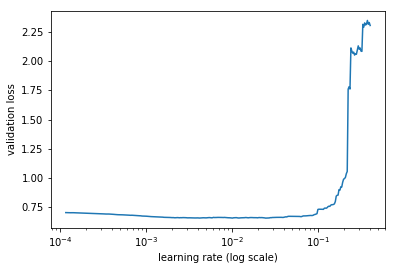

In [123]:
m.lr_find()
m.sched.plot(100)

In [124]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                
    0      0.653093   0.698492  
    1      0.643219   0.702432                                
    2      0.633815   0.698482                                



[array([0.69848])]

In [125]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                
    0      0.629097   0.698218  
    1      0.630482   0.69584                                 
    2      0.627302   0.694849                                
    3      0.626284   0.695622                                
    4      0.625193   0.695162                                



[array([0.69516])]

In [126]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                
    0      0.619256   0.69628   
    1      0.625303   0.697461                                
    2      0.619173   0.69713                                 
    3      0.615027   0.697072                                
    4      0.613455   0.698323                                
    5      0.617816   0.699183                                
    6      0.607251   0.702793                                
    7      0.603086   0.706847                                
    8      0.608087   0.705794                                
    9      0.606741   0.706993                                
    10     0.599062   0.707015                                
    11     0.597749   0.706994                                
    12     0.595749   0.708881                                
    13     0.599025   0.720027                                
    14     0.596037   0.714226                                
    15     0.590444   

[array([0.74771])]

In [127]:
m.save(modelName)

In [128]:
m.load(modelName)

## Validation

In [141]:
(x,y1)=m.predict_with_targs()

In [142]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted':np.argmax(x,axis=1)
})[['Close','index', 'action','predicted']]
valpred.tail(100)

,Close,index,action,predicted
Timestamp,,,,
2017-12-31 23:41:00,13989.799805,2017-12-31 23:41:00,0,0
2017-12-31 23:42:00,13959.870117,2017-12-31 23:42:00,0,1
2017-12-31 23:43:00,13930.000000,2017-12-31 23:43:00,0,1
2017-12-31 23:44:00,13890.950195,2017-12-31 23:44:00,0,1
2017-12-31 23:45:00,13929.959961,2017-12-31 23:45:00,0,1
2017-12-31 23:46:00,13889.009766,2017-12-31 23:46:00,0,1
2017-12-31 23:47:00,13941.610352,2017-12-31 23:47:00,0,1
2017-12-31 23:48:00,13942.349609,2017-12-31 23:48:00,0,1
2017-12-31 23:49:00,13927.339844,2017-12-31 23:49:00,0,1


Calculate the percent accuracy on the validation set

In [143]:
p.calculate_accuracy(valpred)

{'F1Score': 0.539,
 'totalAccuracy': 0.552,
 'buyAccuracy': 0.839,
 'sellAccuracy': 0.239,
 'totalBuyActions': 2089,
 'successfulBuyPredictions': 1752}

In [144]:
p.calculate_net_profit(valpred, 300, 0)
p.result

{'startClose': 14980.22,
 'endClose': 13694.09,
 'startAmount': 300,
 'endAmount': 333.5373450445414,
 'buyAndHoldPercentIncrease': -8.586,
 'percentIncrease': 11.179,
 'percentDifference': 19.765,
 'totalTrades': 333}

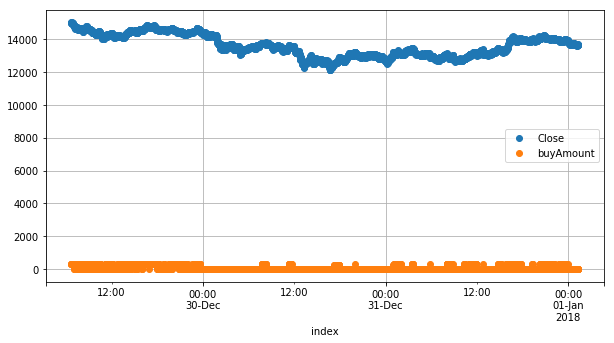

In [146]:
p.plot_profit(p.net_profit_df)

In [147]:
p.net_profit_df

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2017-12-29 06:41:00,14980.219727,2017-12-29 06:41:00,0,0,300.000000,0.000000
2017-12-29 06:42:00,14981.639648,2017-12-29 06:42:00,0,0,300.000000,0.000000
2017-12-29 06:43:00,15014.900391,2017-12-29 06:43:00,0,0,300.000000,0.000000
2017-12-29 06:44:00,14970.000000,2017-12-29 06:44:00,0,0,300.000000,0.000000
2017-12-29 06:45:00,15010.540039,2017-12-29 06:45:00,0,0,300.000000,0.000000
2017-12-29 06:46:00,14920.000000,2017-12-29 06:46:00,0,0,300.000000,0.000000
2017-12-29 06:47:00,14900.509766,2017-12-29 06:47:00,0,0,300.000000,0.000000
2017-12-29 06:48:00,14937.030273,2017-12-29 06:48:00,0,0,300.000000,0.000000
2017-12-29 06:49:00,14936.889648,2017-12-29 06:49:00,0,0,300.000000,0.000000


## Test

In [150]:
np.argmax(m.predict(True), axis =1)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [154]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2018-01-01 01:21:00,2018-01-01 01:21:00,13694.110352,0,1
2018-01-01 01:22:00,2018-01-01 01:22:00,13703.259766,0,1
2018-01-01 01:23:00,2018-01-01 01:23:00,13690.679688,0,1
2018-01-01 01:24:00,2018-01-01 01:24:00,13651.230469,0,1
2018-01-01 01:25:00,2018-01-01 01:25:00,13651.250000,0,1
2018-01-01 01:26:00,2018-01-01 01:26:00,13651.250000,0,1
2018-01-01 01:27:00,2018-01-01 01:27:00,13651.219727,0,1
2018-01-01 01:28:00,2018-01-01 01:28:00,13650.990234,0,1
2018-01-01 01:29:00,2018-01-01 01:29:00,13651.000000,0,0


Calculate the percent accuracy on the test set

In [155]:
p.calculate_accuracy(testPred)

{'F1Score': 0.556,
 'totalAccuracy': 0.592,
 'buyAccuracy': 0.375,
 'sellAccuracy': 0.737,
 'totalBuyActions': 4014,
 'successfulBuyPredictions': 1507}

In [156]:
p.calculate_net_profit(testPred, 300, 0)
p.result

{'startClose': 13694.11,
 'endClose': 16166.78,
 'startAmount': 300,
 'endAmount': 397.43531186129644,
 'buyAndHoldPercentIncrease': 18.056,
 'percentIncrease': 32.478,
 'percentDifference': 14.422,
 'totalTrades': 758}

In [ ]:
p.net_profit_df

In [ ]:
p.plot_profit(p.net_profit_df)